# Importing libraries 

In [1]:
import cv2
import glob
import time
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

from IPython.display import HTML

# Features Extraction

In [2]:
def convert_cspace(img, cspace):
    if cspace == 'RGB':
        feature_img = np.copy(img)
    elif cspace == 'HSV':
        feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif cspace == 'LUV':
        feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif cspace == 'HLS':
        feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif cspace == 'YUV':
        feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif cspace == 'YCrCb':
        feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    return feature_img

def get_hog_features(img, orient, pix_per_cell, cell_per_block, flatten):
    # Otherwise call with one output      

    features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                    cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                    transform_sqrt=True, 
                    visualise=False, feature_vector=flatten)
    return features

def get_hog_features_with_viz(img, orient, pix_per_cell, cell_per_block, flatten):
    # Otherwise call with one output      

    features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                    cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                    transform_sqrt=True, 
                    visualise=True, feature_vector=flatten)
    return features, hog_image

def get_spatial_features(img, size=(32,32)):
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def get_color_hist_features(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features(rgb_img,
                     use_hog_features=True, cspace='HSV', hog_orient=9, hog_pix_per_cell=8, hog_cell_per_block=2, hog_channel='ALL',
                     use_spatial_features=False, spatial_size=(32, 32),
                     use_color_hist_features=False, color_hist_nbins=32, color_hist_bins_range=(0, 256)):
    
    if not (use_hog_features or use_spatial_features or use_color_hist_features):
        raise ValueError('At least one type of feature must be set to True')

    rgb_img = np.uint8((rgb_img / np.max(rgb_img)) * 255)
    feature_img = convert_cspace(rgb_img, cspace)
    feature_vector = []
    if use_hog_features:

        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_img.shape[2]):
                hog_features.append(get_hog_features(feature_img[:,:,channel], hog_orient, hog_pix_per_cell, hog_cell_per_block, flatten=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_img[:,:,hog_channel], hog_orient, hog_pix_per_cell, hog_cell_per_block, flatten=True)
        
        feature_vector.append(hog_features)

    if use_spatial_features:
        spatial_features = get_spatial_features(feature_img, size=spatial_size)
        feature_vector.append(spatial_features)

    if use_color_hist_features:
        hist_features = get_color_hist_features(feature_img, nbins=color_hist_nbins, bins_range=color_hist_bins_range)
        feature_vector.append(hist_features)
    
    feature_vector = np.concatenate(feature_vector)
    
    return feature_vector

# Reading Images

In [3]:
print('Preparing car images ...')
cars = []
for car_img_file in glob.glob('./data/vehicles/GTI_MiddleClose/*.png'): cars.append(car_img_file)
for car_img_file in glob.glob('./data/vehicles/GTI_Far/*.png'): cars.append(car_img_file)
for car_img_file in glob.glob('./data/vehicles/GTI_Right/*.png'): cars.append(car_img_file)
for car_img_file in glob.glob('./data/vehicles/GTI_Left/*.png'): cars.append(car_img_file)
for car_img_file in glob.glob('./data/vehicles/KITTI_extracted/*.png'): cars.append(car_img_file)

print('Preparing not car images ...')
notcars = []
for notcar_img_file in glob.glob('./data/non-vehicles/Extras/*.png'): notcars.append(notcar_img_file)
for notcar_img_file in glob.glob('./data/non-vehicles/GTI/*.png'): notcars.append(notcar_img_file)

print('Number of car images: {}'.format(len(cars)))
print('Number of non car images {}'.format(len(notcars)))

Preparing car images ...
Preparing not car images ...
Number of car images: 8792
Number of non car images 8968


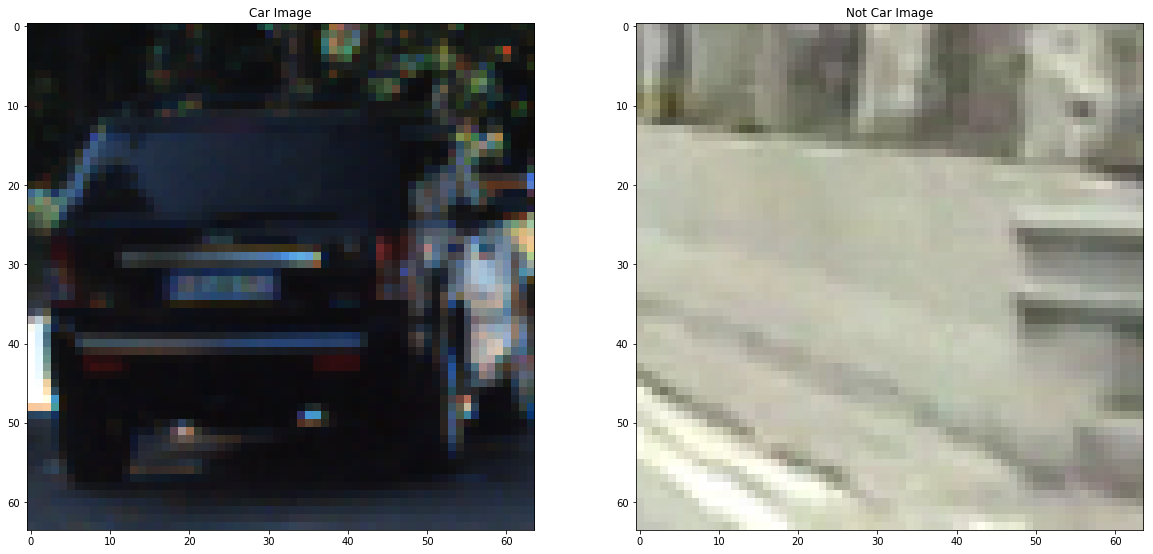

In [4]:
rand_car_idx = np.random.randint(0, len(cars))
rand_notcar_idx = np.random.randint(0, len(notcars))

rand_car_img = mpimg.imread(cars[rand_car_idx])
rand_notcar_img = mpimg.imread(notcars[rand_car_idx])

f, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].imshow(rand_car_img)
axes[0].set_title('Car Image')

axes[1].imshow(rand_notcar_img)
axes[1].set_title('Not Car Image')

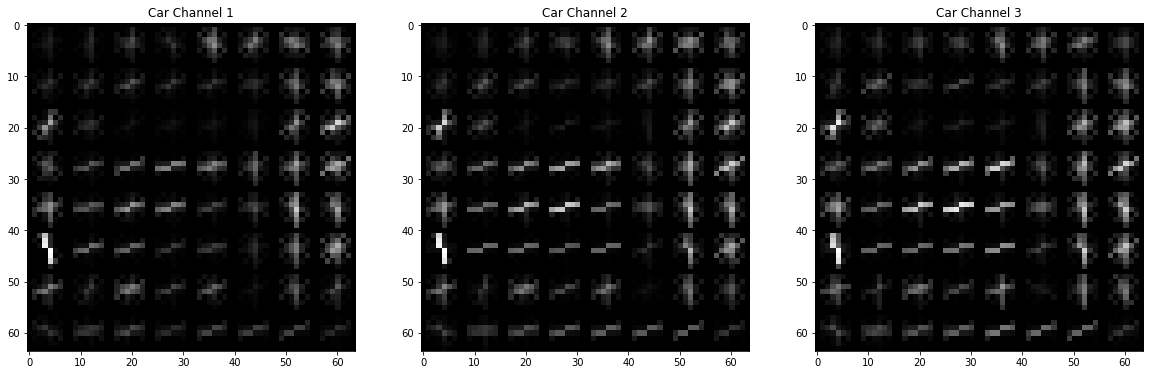

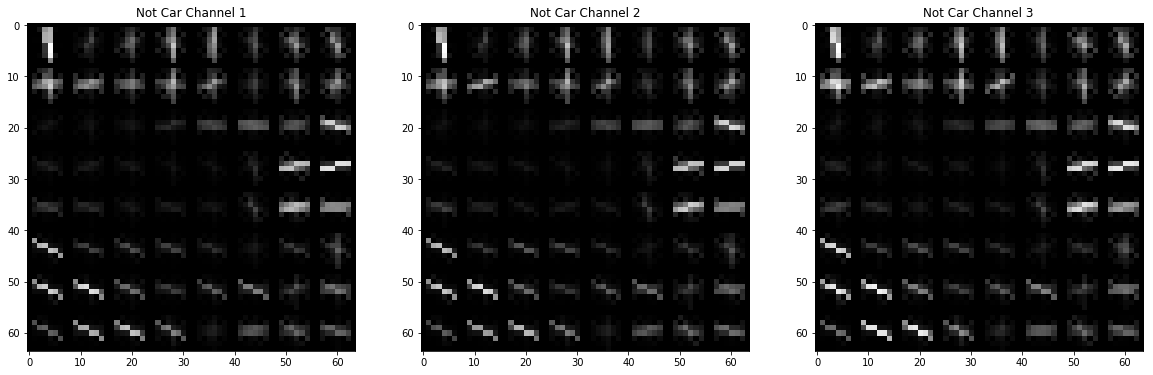

In [5]:
car_ch1 = rand_car_img[:,:,0]
car_ch2 = rand_car_img[:,:,1]
car_ch3 = rand_car_img[:,:,2]

car_hog1_features, car_hog1_img = get_hog_features_with_viz(car_ch1, 11, 8, 2, flatten=False)
car_hog2_features, car_hog2_img = get_hog_features_with_viz(car_ch2, 11, 8, 2, flatten=False)
car_hog3_features, car_hog3_img = get_hog_features_with_viz(car_ch3, 11, 8, 2, flatten=False)

f, car_hog_images = plt.subplots(1, 3, figsize=(20, 10))

car_hog_images[0].imshow(car_hog1_img, cmap='Greys_r')
car_hog_images[0].set_title('Car Channel 1')

car_hog_images[1].imshow(car_hog2_img, cmap='Greys_r')
car_hog_images[1].set_title('Car Channel 2')

car_hog_images[2].imshow(car_hog3_img, cmap='Greys_r')
car_hog_images[2].set_title('Car Channel 3')


notcar_ch1 = rand_notcar_img[:,:,0]
notcar_ch2 = rand_notcar_img[:,:,1]
notcar_ch3 = rand_notcar_img[:,:,2]

notcar_hog1_features, notcar_hog1_img = get_hog_features_with_viz(notcar_ch1, 11, 8, 2, flatten=False)
notcar_hog2_features, notcar_hog2_img = get_hog_features_with_viz(notcar_ch2, 11, 8, 2, flatten=False)
notcar_hog3_features, notcar_hog3_img = get_hog_features_with_viz(notcar_ch3, 11, 8, 2, flatten=False)

f, notcar_hog_images = plt.subplots(1, 3, figsize=(20, 10))

notcar_hog_images[0].imshow(notcar_hog1_img, cmap='Greys_r')
notcar_hog_images[0].set_title('Not Car Channel 1')

notcar_hog_images[1].imshow(notcar_hog2_img, cmap='Greys_r')
notcar_hog_images[1].set_title('Not Car Channel 2')

notcar_hog_images[2].imshow(notcar_hog3_img, cmap='Greys_r')
notcar_hog_images[2].set_title('Not Car Channel 3')

# Extracting Features for Training

In [6]:
use_spatial_feat = True 
use_hist_feat = True 
use_hog_feat = True
hog_pix_per_cell = 8
cspace_used = 'YUV'

print('Extracting car features ...')
car_features = []
for img_path in cars:
    img = mpimg.imread(img_path)
    car_features.append(extract_features(img, use_hog_features=True, 
                                              use_color_hist_features=True, 
                                              use_spatial_features=True, 
                                              cspace=cspace_used,
                                              spatial_size=(16, 16),
                                              color_hist_nbins=32,
                                              hog_orient=11,
                                              hog_pix_per_cell=hog_pix_per_cell,
                                              hog_cell_per_block=2,
                                              hog_channel='ALL'))

print('Extracting not car features ...')
notcar_features = []
for img_path in notcars:
    img = mpimg.imread(img_path)
    notcar_features.append(extract_features(img, use_hog_features=True, 
                                              use_color_hist_features=True, 
                                              use_spatial_features=True, 
                                              cspace=cspace_used,
                                              spatial_size=(16, 16),
                                              color_hist_nbins=32,
                                              hog_orient=11,
                                              hog_pix_per_cell=hog_pix_per_cell,
                                              hog_cell_per_block=2,
                                              hog_channel='ALL'))
    


Extracting car features ...
Extracting not car features ...


# Split train and test data

In [7]:
print('Stacking data ...')
X = np.vstack((car_features, notcar_features)).astype(np.float64)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

print('Shuffling data ...')
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

X_scaler = StandardScaler().fit(X_train)

print('Scaling data ...')
# Fit a per-column scaler only on the training data

# Apply the scaler to X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

Stacking data ...
Shuffling data ...
Scaling data ...


# Training an SVM classifier

In [8]:
svc = LinearSVC()

print('Training data ...')
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Training data ...
27.08 Seconds to train SVC...
Test Accuracy of SVC =  0.9848


# Function to find cars

In [9]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, 
             use_hog_features=True, cspace='RGB', hog_orient=9, hog_pix_per_cell=8, hog_cell_per_block=2, hog_channel='ALL',
             use_spatial_features=True, spatial_size=(32, 32),
             use_color_hist_features=True, color_hist_nbins=32, color_hist_bins_range=(0, 256)):
    
    bbox_list = []
    #draw_img = np.copy(img)
    img = np.uint8((img / np.max(img)) * 255)
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_cspace(img_tosearch, cspace)
    
    
    if scale != 1:
        imshape = img_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // hog_pix_per_cell) - hog_cell_per_block + 1
    nyblocks = (ch1.shape[0] // hog_pix_per_cell) - hog_cell_per_block + 1 
    nfeat_per_block = hog_orient*hog_cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // hog_pix_per_cell) - hog_cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, hog_orient, hog_pix_per_cell, hog_cell_per_block, flatten=False)
    hog2 = get_hog_features(ch2, hog_orient, hog_pix_per_cell, hog_cell_per_block, flatten=False)
    hog3 = get_hog_features(ch3, hog_orient, hog_pix_per_cell, hog_cell_per_block, flatten=False)

        
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*hog_pix_per_cell
            ytop = ypos*hog_pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            spatial_features = get_spatial_features(subimg, size=spatial_size)
            
            # Get color features
            hist_features = get_color_hist_features(subimg, nbins=color_hist_nbins)
            
            feature_vector = np.hstack((hog_features, spatial_features, hist_features))
            #print('hog shape {}, spatial shape {}, hist_shape {}'.format(hog_features.shape, spatial_features.shape, hist_features.shape))
            
            #print('scaler mean {}'.format(X_scaler.mean_.shape))
            # Scale features and make a prediction
            test_features = X_scaler.transform(feature_vector.reshape(1, -1))   
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox = ( (xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart) )
                bbox_list.append(bbox)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return bbox_list

# Functions to draw rectangles

In [10]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



# Classify on test images

Reading test image
Find cars ...


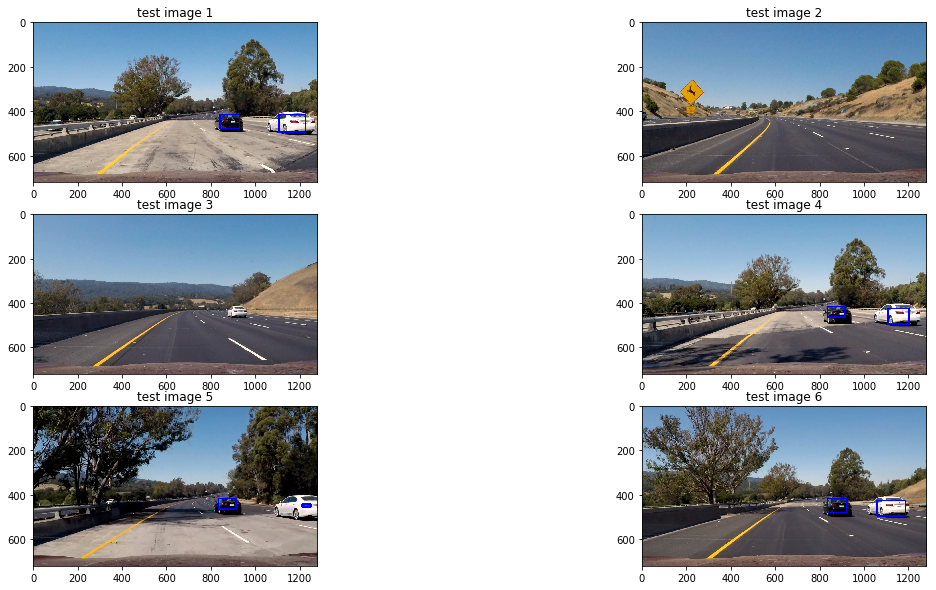

In [11]:
print('Reading test image')

test_images = glob.glob('./test_images/*.jpg')

print('Find cars ...')

draw_imgs = []

for test_image in test_images:

    image = mpimg.imread(test_image)

    bbox_list0 = find_cars(image, 400, 500, 0.5, svc, X_scaler, use_hog_features=True, 
                                                  use_color_hist_features=True, 
                                                  use_spatial_features=True, 
                                                  cspace=cspace_used,
                                                  spatial_size=(16, 16),
                                                  color_hist_nbins=32,
                                                  hog_orient=11,
                                                  hog_pix_per_cell=hog_pix_per_cell,
                                                  hog_cell_per_block=2,
                                                  hog_channel='ALL')

    bbox_list1 = find_cars(image, 400, 600, 1, svc, X_scaler, use_hog_features=True, 
                                                  use_color_hist_features=True, 
                                                  use_spatial_features=True, 
                                                  cspace=cspace_used,
                                                  spatial_size=(16, 16),
                                                  color_hist_nbins=32,
                                                  hog_orient=11,
                                                  hog_pix_per_cell=hog_pix_per_cell,
                                                  hog_cell_per_block=2,
                                                  hog_channel='ALL')

    bbox_list2 = find_cars(image, 400, 650, 1.5, svc, X_scaler, use_hog_features=True, 
                                                  use_color_hist_features=True, 
                                                  use_spatial_features=True, 
                                                  cspace=cspace_used,
                                                  spatial_size=(16, 16),
                                                  color_hist_nbins=32,
                                                  hog_orient=11,
                                                  hog_pix_per_cell=hog_pix_per_cell,
                                                  hog_cell_per_block=2,
                                                  hog_channel='ALL')

    bbox_list3 = find_cars(image, 400, 656, 2, svc, X_scaler, use_hog_features=True, 
                                                  use_color_hist_features=True, 
                                                  use_spatial_features=True, 
                                                  cspace=cspace_used,
                                                  spatial_size=(16, 16),
                                                  color_hist_nbins=32,
                                                  hog_orient=11,
                                                  hog_pix_per_cell=hog_pix_per_cell,
                                                  hog_cell_per_block=2,
                                                  hog_channel='ALL')

    bbox_list4 = find_cars(image, 400, 656, 2.5, svc, X_scaler, use_hog_features=True, 
                                                  use_color_hist_features=True, 
                                                  use_spatial_features=True, 
                                                  cspace=cspace_used,
                                                  spatial_size=(16, 16),
                                                  color_hist_nbins=32,
                                                  hog_orient=11,
                                                  hog_pix_per_cell=hog_pix_per_cell,
                                                  hog_cell_per_block=2,
                                                  hog_channel='ALL')

    bbox_list = bbox_list0 + bbox_list1 + bbox_list2 + bbox_list3 + bbox_list4
    # Add heat to each box in box list
    heat = np.zeros_like(image[:,:,0])
    heat = add_heat(heat, bbox_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 15)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_imgs.append(draw_labeled_bboxes(np.copy(image), labels))
    
    
f, axes = plt.subplots(3, 2, figsize=(20, 10))

axes[0, 0].imshow(draw_imgs[0])
axes[0, 0].set_title('test image 1')

axes[0, 1].imshow(draw_imgs[1])
axes[0, 1].set_title('test image 2')

axes[1, 0].imshow(draw_imgs[2])
axes[1, 0].set_title('test image 3')

axes[1, 1].imshow(draw_imgs[3])
axes[1, 1].set_title('test image 4')

axes[2, 0].imshow(draw_imgs[4])
axes[2, 0].set_title('test image 5')

axes[2, 1].imshow(draw_imgs[5])
axes[2, 1].set_title('test image 6')



# Classify on video 

In [14]:
from moviepy.editor import VideoFileClip
def detect_vehicles_frame(frame):
    
    bbox_list0 = find_cars(frame, 400, 500, 0.5, svc, X_scaler, use_hog_features=True, 
                                                  use_color_hist_features=True, 
                                                  use_spatial_features=True, 
                                                  cspace=cspace_used,
                                                  spatial_size=(16, 16),
                                                  color_hist_nbins=32,
                                                  hog_orient=11,
                                                  hog_pix_per_cell=hog_pix_per_cell,
                                                  hog_cell_per_block=2,
                                                  hog_channel='ALL')

    bbox_list1 = find_cars(frame, 400, 600, 1, svc, X_scaler, use_hog_features=True, 
                                                  use_color_hist_features=True, 
                                                  use_spatial_features=True, 
                                                  cspace=cspace_used,
                                                  spatial_size=(16, 16),
                                                  color_hist_nbins=32,
                                                  hog_orient=11,
                                                  hog_pix_per_cell=hog_pix_per_cell,
                                                  hog_cell_per_block=2,
                                                  hog_channel='ALL')

    bbox_list2 = find_cars(frame, 400, 650, 1.5, svc, X_scaler, use_hog_features=True, 
                                                  use_color_hist_features=True, 
                                                  use_spatial_features=True, 
                                                  cspace=cspace_used,
                                                  spatial_size=(16, 16),
                                                  color_hist_nbins=32,
                                                  hog_orient=11,
                                                  hog_pix_per_cell=hog_pix_per_cell,
                                                  hog_cell_per_block=2,
                                                  hog_channel='ALL')

    bbox_list3 = find_cars(frame, 400, 656, 2, svc, X_scaler, use_hog_features=True, 
                                                  use_color_hist_features=True, 
                                                  use_spatial_features=True, 
                                                  cspace=cspace_used,
                                                  spatial_size=(16, 16),
                                                  color_hist_nbins=32,
                                                  hog_orient=11,
                                                  hog_pix_per_cell=hog_pix_per_cell,
                                                  hog_cell_per_block=2,
                                                  hog_channel='ALL')

    bbox_list4 = find_cars(frame, 400, 656, 2.5, svc, X_scaler, use_hog_features=True, 
                                                  use_color_hist_features=True, 
                                                  use_spatial_features=True, 
                                                  cspace=cspace_used,
                                                  spatial_size=(16, 16),
                                                  color_hist_nbins=32,
                                                  hog_orient=11,
                                                  hog_pix_per_cell=hog_pix_per_cell,
                                                  hog_cell_per_block=2,
                                                  hog_channel='ALL')

    bbox_list = bbox_list0 + bbox_list1 + bbox_list2 + bbox_list3 + bbox_list4
    
    # Add heat to each box in box list
    heat = np.zeros_like(frame[:,:,0])
    heat = add_heat(heat, bbox_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 15)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    return draw_labeled_bboxes(np.copy(frame), labels)

def detect_vehicles_video(video_in_path, video_out_path):
    video_in = VideoFileClip(video_in_path)
    processed_video_in = video_in.fl_image(detect_vehicles_frame)
    processed_video_in.write_videofile(video_out_path, audio=False) 


In [ ]:
detect_vehicles_video('project_video.mp4', 'out_test_video.mp4')

HTML("""
<video width="1280" height="760" controls>
  <source src="{0}">
</video>
""".format('out_test_video.mp4'))

# TODO: visualize area where sliding window search and only search small windows closer to middle

[MoviePy] >>>> Building video out_test_video.mp4
[MoviePy] Writing video out_test_video.mp4


 83%|███████████████████████████████████████████████████████████████▍            | 1052/1261 [1:36:47<19:28,  5.59s/it]